1.Import Thư viện



In [1]:
# Thư viện cơ bản
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential # type: ignore
from keras.layers import LSTM, Dropout, Dense # type: ignore
from keras.callbacks import ModelCheckpoint # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from pymongo import MongoClient
import os

2. Đọc Dữ Liệu

In [2]:
# Kết nối MongoDB và lấy dữ liệu
client = MongoClient("mongodb://localhost:27017/")  # Đường dẫn kết nối
db = client['data']  # Tên database
collection = db['FPT']  # Collection của mã cổ phiếu

In [3]:
# Chuyển dữ liệu từ MongoDB sang DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))

In [8]:
df

,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2006-12-13,11.52,400.0,83530,33412000,0,0,400.0,400.0,400.0,0.0,0.00
1,2006-12-14,12.09,420.0,280710,117898200,96000,36480000,420.0,420.0,420.0,0.0,0.00
2,2006-12-15,12.70,441.0,265300,116997300,30000,12200000,441.0,441.0,441.0,0.0,0.00
3,2006-12-18,13.33,463.0,215790,99910770,10000,4410000,463.0,463.0,463.0,0.0,0.00
4,2006-12-19,13.99,486.0,137520,66834720,0,0,486.0,486.0,486.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
4474,2024-11-25,133.90,133.9,1849700,247302000000,4788000,663253000000,134.0,134.0,133.2,0.0,0.00
4475,2024-11-26,135.20,135.2,4176100,562870000000,325000,44570000000,133.4,135.9,133.3,1.3,0.97
4476,2024-11-27,138.90,138.9,9814300,1358066000000,3452000,470898000000,135.2,139.7,135.2,3.7,2.74
4477,2024-11-28,139.40,139.4,4742700,660343000000,2336000,323190800000,139.4,140.0,138.3,0.5,0.36


In [4]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4479 entries, 0 to 4478
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               4479 non-null   object 
 1   GiaDieuChinh       4479 non-null   float64
 2   GiaDongCua         4479 non-null   float64
 3   KhoiLuongKhopLenh  4479 non-null   int64  
 4   GiaTriKhopLenh     4479 non-null   int64  
 5   KLThoaThuan        4479 non-null   int64  
 6   GtThoaThuan        4479 non-null   int64  
 7   GiaMoCua           4479 non-null   float64
 8   GiaCaoNhat         4479 non-null   float64
 9   GiaThapNhat        4479 non-null   float64
 10  ThayDoi_GiaTri     4479 non-null   float64
 11  ThayDoi_PhanTram   4479 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 420.0+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,4479.000000,4479.000000,4.479000e+03,4.479000e+03,4.479000e+03,4.479000e+03,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000
mean,24.145048,82.751808,1.075234e+06,8.694873e+10,2.446391e+05,1.910911e+10,82.771478,83.604476,81.954622,0.035740,0.066591
std,29.203260,83.817376,1.295307e+06,1.455500e+11,8.090372e+05,5.909821e+10,83.889387,84.586977,83.084947,1.163438,1.539805
min,2.120000,32.300000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,32.200000,32.600000,32.100000,-30.400000,-11.030000
25%,6.090000,47.200000,2.440450e+05,1.556872e+10,0.000000e+00,0.000000e+00,47.200000,47.600000,46.900000,-0.300000,-0.495000
50%,10.970000,55.700000,6.224000e+05,4.054124e+10,0.000000e+00,0.000000e+00,56.000000,56.500000,55.000000,0.000000,0.000000
75%,24.375000,84.000000,1.443380e+06,9.494500e+10,1.572500e+05,9.979392e+09,84.050000,84.900000,83.150000,0.400000,0.630000
max,142.100000,665.000000,1.370680e+07,1.782682e+12,2.276401e+07,1.126501e+12,665.000000,672.000000,665.000000,11.500000,7.000000


3. Tiền Xử Lý Dữ Liệu

In [12]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

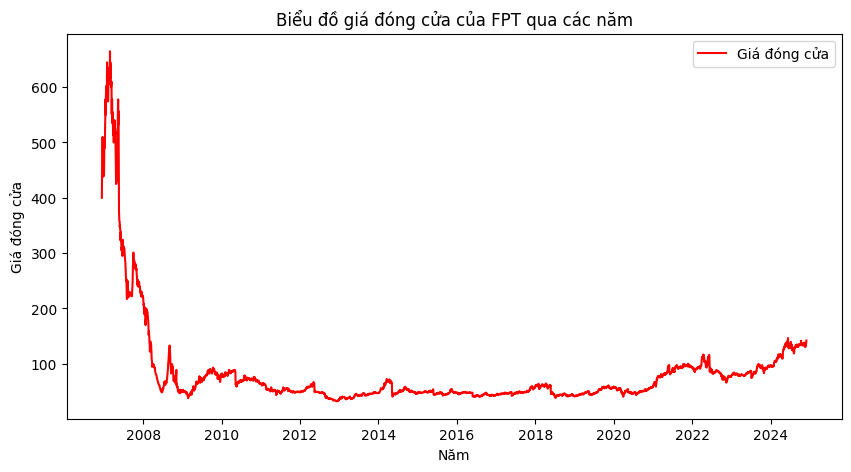

In [13]:
# Vẽ biểu đồ giá đóng cửa
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của FPT qua các năm')
plt.legend(loc='best')
plt.show()

In [14]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [15]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [16]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [17]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

4. Xây Dựng và Huấn Luyện Mô Hình

In [ ]:
# Hàm xây dựng mô hình
def build_model():
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(x_train.shape[1], 1), return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [ ]:
# Huấn luyện mô hình
model = build_model()
save_model_path = "save_models/FPT_model1.keras"
best_model = ModelCheckpoint(save_model_path, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])

5. Đánh Giá Mô Hình

In [18]:
save_model_path = "models/FPT_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)

In [19]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


In [20]:
# Đánh giá trên tập train
print('Độ phù hợp tập train:', r2_score(y_train, y_train_predict))
print('Sai số tuyệt đối trung bình tập train:', mean_absolute_error(y_train, y_train_predict))
print('Phần trăm sai số tuyệt đối trung bình tập train:', mean_absolute_percentage_error(y_train, y_train_predict))

Độ phù hợp tập train: 0.9971275790933731
Sai số tuyệt đối trung bình tập train: 1.3239679351124247
Phần trăm sai số tuyệt đối trung bình tập train: 0.015023975980722967


6. Dự Đoán trên Tập Test

In [21]:
# Xử lý dữ liệu test
test = df1[len(train_data) - 50:].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

x_test = []
for i in range(50, test.shape[0]):
    x_test.append(sc_test[i - 50:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [22]:
# Dự đoán trên tập test
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [23]:
# Đánh giá trên tập test
print('Độ phù hợp tập test:', r2_score(test_data, y_test_predict))
print('Sai số tuyệt đối trung bình tập test:', mean_absolute_error(test_data, y_test_predict))
print('Phần trăm sai số tuyệt đối trung bình tập test:', mean_absolute_percentage_error(test_data, y_test_predict))

Độ phù hợp tập test: 0.9890703003071978
Sai số tuyệt đối trung bình tập test: 1.183630134378161
Phần trăm sai số tuyệt đối trung bình tập test: 0.012089675402769359


7. Dự Báo Giá Tương Lai

In [26]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1500:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


ValueError: Length of values (3533) does not match length of index (1450)

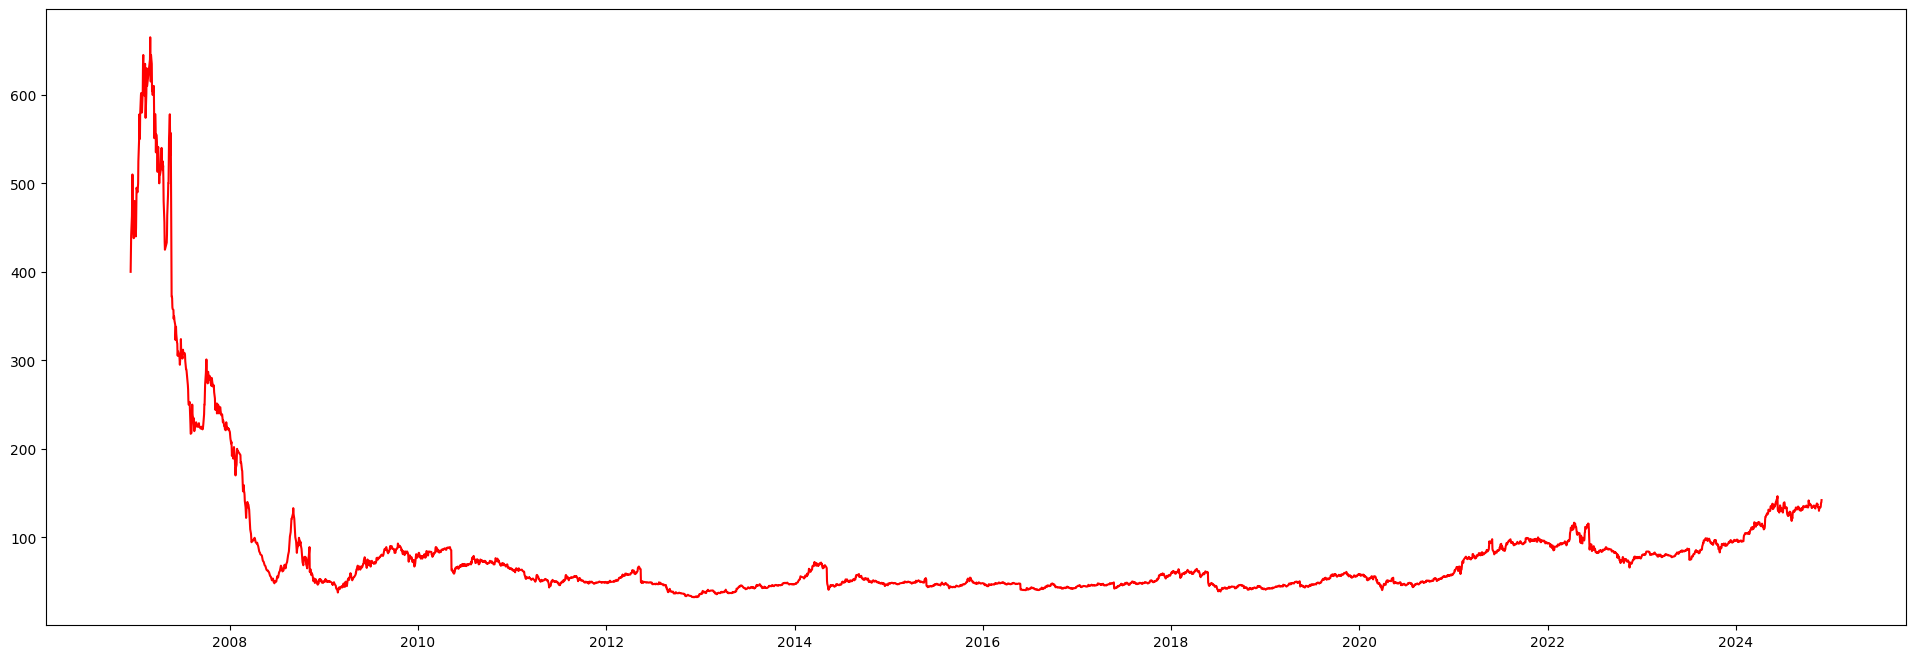

In [27]:
#lập biểu đồ so sánh
train_data1 = df1[50:1500]
test_data1 = df1[1500:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

8. So Sánh Giá Dự Báo và Thực Tế

In [ ]:
# Lấy giá trị thực tế ngày cuối
actual_closing_price = df['GiaDongCua'].iloc[-1]

# Tạo bảng so sánh
comparison_df = pd.DataFrame({
    'Ngày': [predicted_dates[0]],
    'Giá dự đoán': [predicted_prices[0]],
    'Giá thực tế ngày cuối': [actual_closing_price]
})

print(comparison_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16600 entries, 0 to 16599
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               16600 non-null  object 
 1   GiaDieuChinh       16600 non-null  float64
 2   GiaDongCua         16600 non-null  float64
 3   KhoiLuongKhopLenh  16600 non-null  int64  
 4   GiaTriKhopLenh     16600 non-null  float64
 5   KLThoaThuan        16600 non-null  int64  
 6   GtThoaThuan        16600 non-null  float64
 7   GiaMoCua           16600 non-null  float64
 8   GiaCaoNhat         16600 non-null  float64
 9   GiaThapNhat        16600 non-null  float64
 10  ThayDoi_GiaTri     16600 non-null  float64
 11  ThayDoi_PhanTram   16600 non-null  float64
 12  Mã                 16600 non-null  object 
dtypes: float64(9), int64(2), object(2)
memory usage: 1.6+ MB
None
       GiaDieuChinh    GiaDongCua  KhoiLuongKhopLenh  GiaTriKhopLenh  \
count  16600.000000  16600.00000

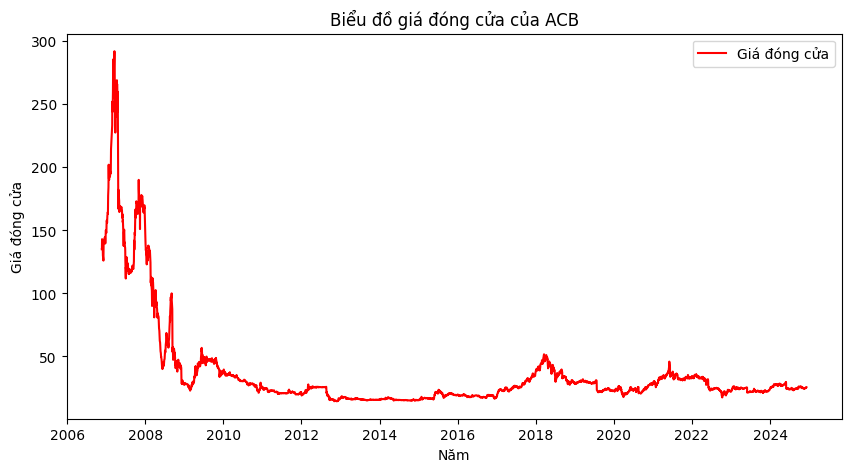

x_train_all shape: (16350, 50, 1)
y_train_all shape: (16350,)


In [65]:
# Thư viện cơ bản
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential  # type: ignore
from keras.layers import LSTM, Dropout, Dense  # type: ignore
from keras.callbacks import ModelCheckpoint  # type: ignore
from tensorflow.keras.models import load_model  # type: ignore
from pymongo import MongoClient
import os

# 2. Đọc Dữ Liệu
# Kết nối MongoDB và lấy dữ liệu
client = MongoClient("mongodb://localhost:27017/")  # Đường dẫn kết nối
db = client['metadata']  # Tên database

# Danh sách các mã cổ phiếu
stock_codes = ['ACB', 'BCM', 'BID', 'BVH', 'CTG']
df_list = []

# Lấy dữ liệu của từng mã cổ phiếu từ MongoDB
for code in stock_codes:
    collection = db[code]  # Truy cập từng collection theo mã cổ phiếu
    data = pd.DataFrame(list(collection.find({}, {"_id": 0})))
    data['Mã'] = code  # Thêm thông tin mã cổ phiếu
    df_list.append(data)

# Kết hợp tất cả dữ liệu lại
df = pd.concat(df_list, ignore_index=True)

# Kiểm tra dữ liệu
print(df.info())
print(df.describe())

# 3. Tiền Xử Lý Dữ Liệu
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by=['Mã', 'Ngay'])  # Sắp xếp theo Mã cổ phiếu và Ngày

# Vẽ biểu đồ giá đóng cửa cho một cổ phiếu ví dụ
plt.figure(figsize=(10, 5))
sample_stock = df[df['Mã'] == 'ACB']  # Lấy dữ liệu cho mã cổ phiếu ACB
plt.plot(sample_stock['Ngay'], sample_stock['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của ACB')
plt.legend(loc='best')
plt.show()

# Chuyển đổi sang chỉ số thời gian cho mỗi mã cổ phiếu
df1 = df[['Ngay', 'GiaDongCua', 'Mã']]
df1.set_index(['Mã', 'Ngay'], inplace=True)

# Chuẩn hóa dữ liệu và tạo cửa sổ thời gian cho mỗi mã cổ phiếu
sc = MinMaxScaler(feature_range=(0, 1))

# Tạo danh sách dữ liệu huấn luyện và kiểm tra
x_train_list, y_train_list = [], []
for code in stock_codes:
    stock_data = df1.xs(code, level='Mã')
    stock_values = stock_data['GiaDongCua'].values.reshape(-1, 1)
    stock_scaled = sc.fit_transform(stock_values)

    # Tạo cửa sổ thời gian cho dữ liệu huấn luyện
    x_train, y_train = [], []
    for i in range(50, len(stock_scaled)):
        x_train.append(stock_scaled[i - 50:i, 0])  # 50 giá trị trước đó
        y_train.append(stock_scaled[i, 0])  # Giá trị tiếp theo
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    # Thêm vào danh sách chung
    x_train_list.append(x_train)
    y_train_list.append(y_train)

# Ghép tất cả dữ liệu lại
x_train_all = np.concatenate(x_train_list, axis=0)
y_train_all = np.concatenate(y_train_list, axis=0)

# Kiểm tra kích thước dữ liệu
print(f"x_train_all shape: {x_train_all.shape}")
print(f"y_train_all shape: {y_train_all.shape}")


111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
Độ phù hợp tập train: 0.997127265368743
Sai số tuyệt đối trung bình tập train: 1.3235068524257927
Phần trăm sai số tuyệt đối trung bình tập train: 0.015019114839405991
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Độ phù hợp tập test: 0.9892750846630338
Sai số tuyệt đối trung bình tập test: 1.1953361638812319
Phần trăm sai số tuyệt đối trung bình tập test: 0.012145793409974714
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\TRUONG\AppData\Local\Temp\ipykernel_3308\4184863716.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict


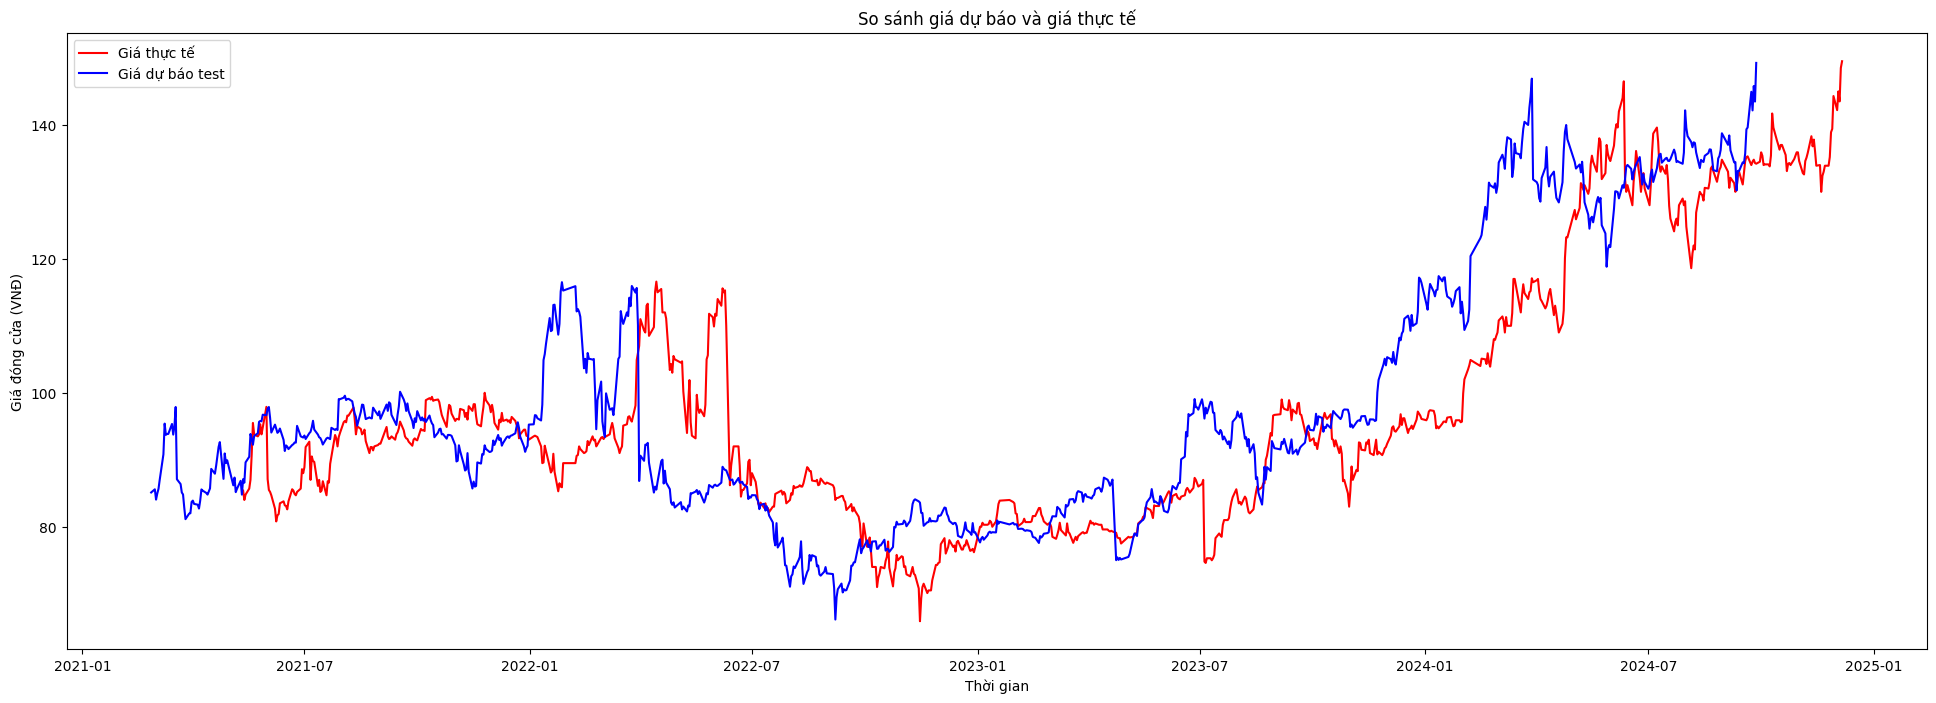

In [ ]:
# 5. Đánh Giá Mô Hình
save_model_path = "models/FPT_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)  # Inverse transform the predictions
y_train = sc.inverse_transform(y_train.reshape(-1, 1))
# Đánh giá trên tập train
print('Độ phù hợp tập train:', r2_score(y_train, y_train_predict))
print('Sai số tuyệt đối trung bình tập train:', mean_absolute_error(y_train, y_train_predict))
print('Phần trăm sai số tuyệt đối trung bình tập train:', mean_absolute_percentage_error(y_train, y_train_predict))

# 6. Dự Đoán trên Tập Test
# Xử lý dữ liệu test
test = df1[len(train_data) - 50:].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

x_test = []
for i in range(50, test.shape[0]):
    x_test.append(sc_test[i - 50:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Dự đoán trên tập test
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict)  # Inverse transform the predictions

# Đánh giá trên tập test
print('Độ phù hợp tập test:', r2_score(test_data, y_test_predict))
print('Sai số tuyệt đối trung bình tập test:', mean_absolute_error(test_data, y_test_predict))
print('Phần trăm sai số tuyệt đối trung bình tập test:', mean_absolute_percentage_error(test_data, y_test_predict))

# 7. Dự Báo Giá Tương Lai

# Xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

x_test = []
for i in range(50, test.shape[0]):
    x_test.append(sc_test[i - 50:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Lấy dữ liệu dự báo trên tập test
test_data1['Dự đoán'] = y_test_predict.flatten()  # Dự đoán đã được biến đổi sang dạng một chiều

# Đảm bảo dữ liệu thực tế và dự báo có cùng khoảng thời gian
test_data1 = test_data1.iloc[:len(y_test_predict)]  # Lọc chính xác các dòng tương ứng với dữ liệu dự báo

# Vẽ biểu đồ
plt.figure(figsize=(24, 8))

# Vẽ giá thực tế
plt.plot(df1.index[len(train_data):], df1['GiaDongCua'].iloc[len(train_data):], label='Giá thực tế', color='red')

# Vẽ giá dự báo trên tập test
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự báo test', color='blue')

# Chú thích và định dạng biểu đồ
plt.title(f'So sánh giá dự báo và giá thực tế của {collection_name}')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.grid(True)
plt.show()

# 8. So Sánh Giá Dự Báo và Thực Tế
# Lấy giá trị thực tế từ tập test
actual_closing_price_test = df1['GiaDongCua'].iloc[len(train_data):].values  # Giá thực tế từ test


In [63]:
# Ensure that the predicted values correspond to the last 30 dates of test data
actual_last_30 = df['GiaDongCua'].iloc[-35:].values  # Last 30 actual values
predicted_last_30 = y_test_predict[-35:].flatten()  # Ensure the prediction is 1D

# Create a DataFrame comparing actual and predicted values for the last 30 days
comparison_df = pd.DataFrame({
    'Ngày': df['Ngay'].iloc[-35:],  # Last 30 dates
    'Giá thực tế': actual_last_30,  # Actual closing prices for the last 30 days
    'Giá dự đoán': predicted_last_30  # Predicted closing prices for the last 30 days
})

print(comparison_df)


           Ngày  Giá thực tế  Giá dự đoán
4449 2024-10-21        135.5   137.291473
4450 2024-10-22        133.1   135.875854
4451 2024-10-23        134.2   133.551773
4452 2024-10-24        134.3   134.772263
4453 2024-10-25        134.0   134.569519
4454 2024-10-28        134.9   134.459595
4455 2024-10-29        135.4   135.376511
4456 2024-10-30        135.9   135.789200
4457 2024-10-31        135.9   136.344543
4458 2024-11-01        134.6   136.302719
4459 2024-11-04        132.8   134.998291
4460 2024-11-05        132.6   133.245941
4461 2024-11-06        134.6   133.068649
4462 2024-11-07        135.1   134.991516
4463 2024-11-08        135.8   135.354935
4464 2024-11-11        138.3   136.251892
4465 2024-11-12        136.8   138.742935
4466 2024-11-13        137.8   137.019012
4467 2024-11-14        136.0   138.420761
4468 2024-11-15        133.9   136.203262
4469 2024-11-18        134.0   134.401276
4470 2024-11-19        130.0   134.444595
4471 2024-11-20        132.4   130

Xử lý dữ liệu cho Collection: VIC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4297 entries, 0 to 4296
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               4297 non-null   object 
 1   GiaDieuChinh       4297 non-null   float64
 2   GiaDongCua         4297 non-null   float64
 3   KhoiLuongKhopLenh  4297 non-null   int64  
 4   GiaTriKhopLenh     4297 non-null   float64
 5   KLThoaThuan        4297 non-null   int64  
 6   GtThoaThuan        4297 non-null   float64
 7   GiaMoCua           4297 non-null   float64
 8   GiaCaoNhat         4297 non-null   float64
 9   GiaThapNhat        4297 non-null   float64
 10  ThayDoi_GiaTri     4297 non-null   float64
 11  ThayDoi_PhanTram   4297 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 403.0+ KB
None
       GiaDieuChinh   GiaDongCua  KhoiLuongKhopLenh  GiaTriKhopLenh  \
count   4297.000000  4297.000000       4.297000

C:\Users\TRUONG\AppData\Local\Temp\ipykernel_3308\3343373452.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1_resized['Dự đoán'] = y_test_predict  # Gắn dự đoán vào test_data1_resized


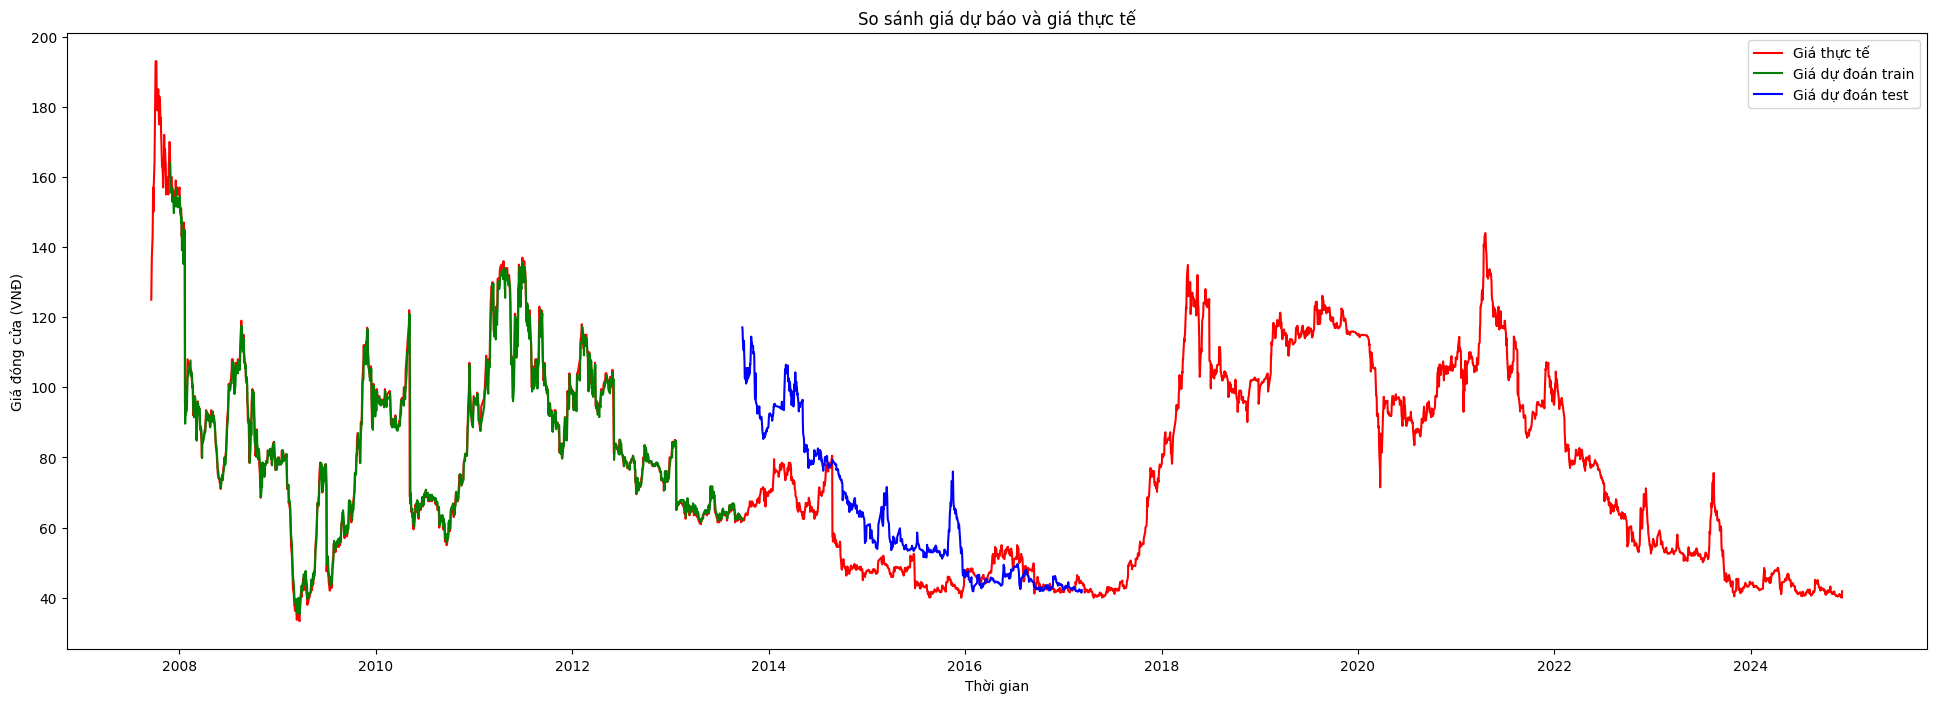

           Ngày  Giá thực tế  Giá dự đoán
4287 2024-11-25        41.00    41.837410
4288 2024-11-26        41.05    42.326462
4289 2024-11-27        40.75    42.400547
4290 2024-11-28        40.70    42.156776
4291 2024-11-29        40.50    42.104908
4292 2024-12-02        40.35    41.917145
4293 2024-12-03        40.40    41.769108
4294 2024-12-04        40.00    41.797729
4295 2024-12-05        40.85    41.443428
4296 2024-12-06        41.85    42.170277
Kết thúc xử lý cho VIC

Xử lý dữ liệu cho Collection: VJC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               1946 non-null   object 
 1   GiaDieuChinh       1946 non-null   float64
 2   GiaDongCua         1946 non-null   float64
 3   KhoiLuongKhopLenh  1946 non-null   int64  
 4   GiaTriKhopLenh     1946 non-null   float64
 5   KLThoaThuan        1946 non-null

C:\Users\TRUONG\AppData\Local\Temp\ipykernel_3308\3343373452.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1_resized['Dự đoán'] = y_test_predict  # Gắn dự đoán vào test_data1_resized


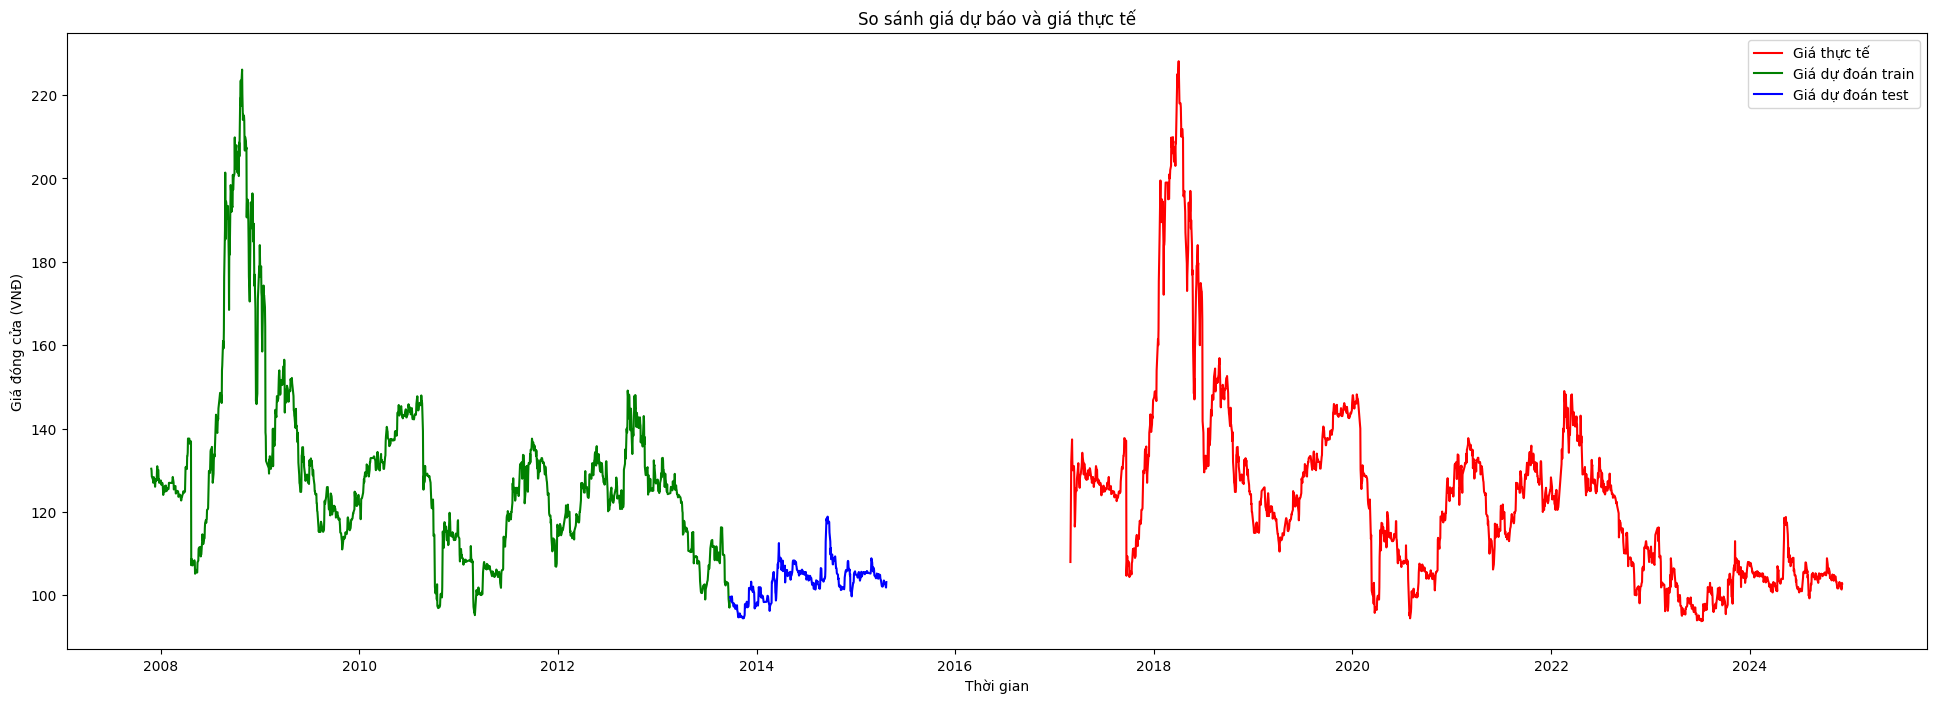

           Ngày  Giá thực tế  Giá dự đoán
1936 2024-11-25        102.8   102.143112
1937 2024-11-26        103.2   103.066750
1938 2024-11-27        102.4   103.567001
1939 2024-11-28        102.2   102.962509
1940 2024-11-29        102.4   102.681641
1941 2024-12-02        102.3   102.812561
1942 2024-12-03        101.5   102.755013
1943 2024-12-04        101.4   102.072151
1944 2024-12-05        103.0   101.869698
1945 2024-12-06        102.8   103.190552
Kết thúc xử lý cho VJC

Xử lý dữ liệu cho Collection: VNM
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               4711 non-null   object 
 1   GiaDieuChinh       4711 non-null   float64
 2   GiaDongCua         4711 non-null   float64
 3   KhoiLuongKhopLenh  4711 non-null   int64  
 4   GiaTriKhopLenh     4711 non-null   float64
 5   KLThoaThuan        4711 non-null

C:\Users\TRUONG\AppData\Local\Temp\ipykernel_3308\3343373452.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1_resized['Dự đoán'] = y_test_predict  # Gắn dự đoán vào test_data1_resized


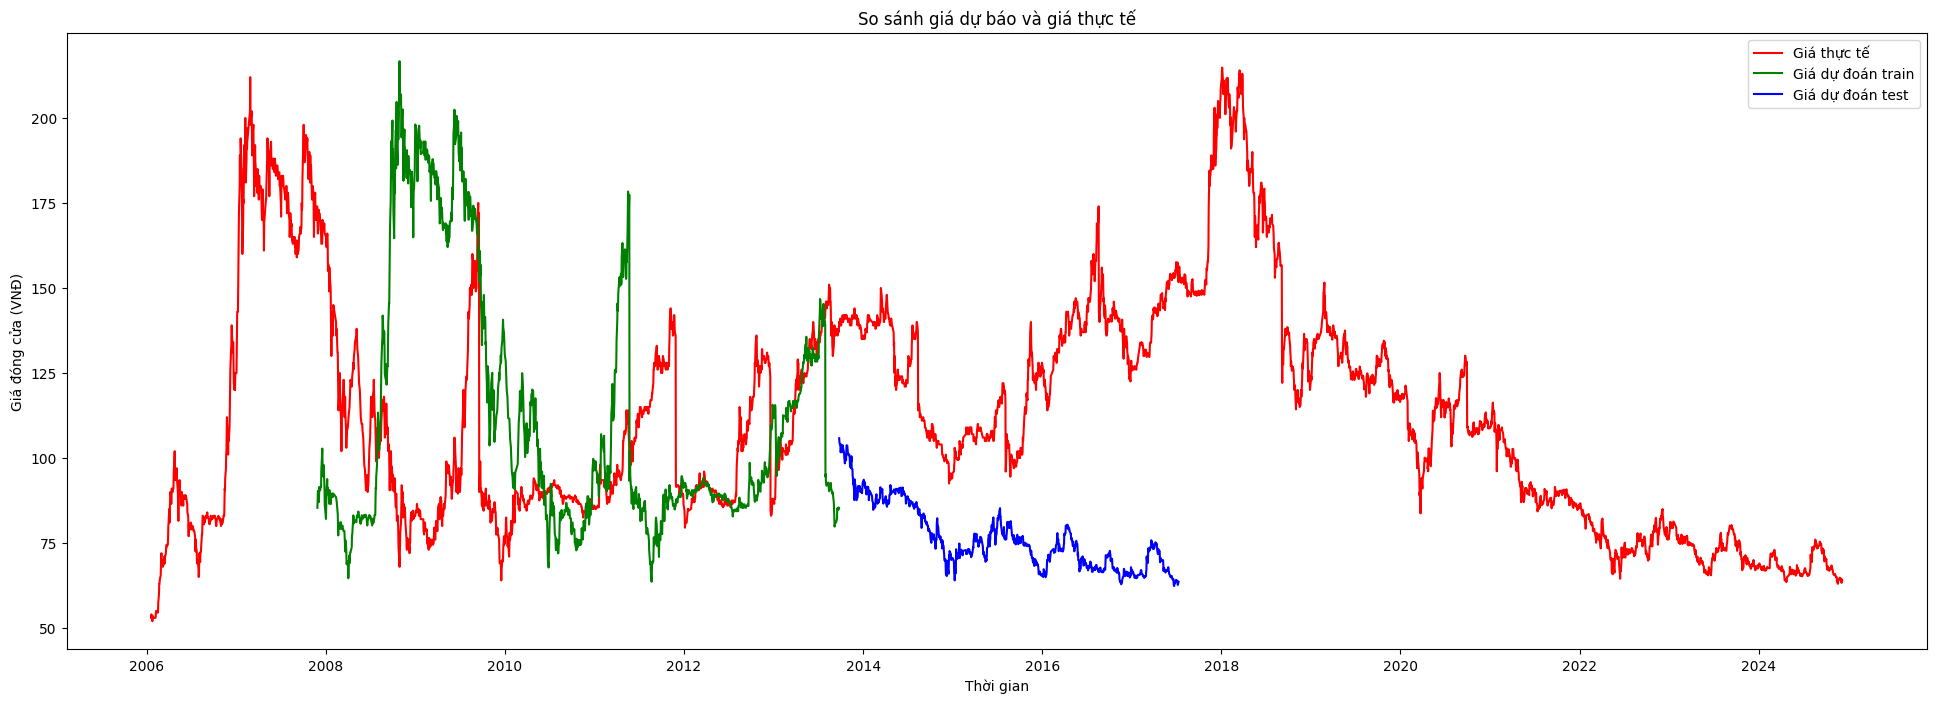

           Ngày  Giá thực tế  Giá dự đoán
4701 2024-11-25         64.3    63.602493
4702 2024-11-26         64.8    63.641705
4703 2024-11-27         64.6    64.149757
4704 2024-11-28         64.5    63.981041
4705 2024-11-29         64.6    63.884605
4706 2024-12-02         64.5    63.980274
4707 2024-12-03         63.9    63.877182
4708 2024-12-04         63.3    63.283623
4709 2024-12-05         64.3    62.672604
4710 2024-12-06         64.1    63.610546
Kết thúc xử lý cho VNM

Xử lý dữ liệu cho Collection: VPB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               1827 non-null   object 
 1   GiaDieuChinh       1827 non-null   float64
 2   GiaDongCua         1827 non-null   float64
 3   KhoiLuongKhopLenh  1827 non-null   int64  
 4   GiaTriKhopLenh     1827 non-null   float64
 5   KLThoaThuan        1827 non-null

C:\Users\TRUONG\AppData\Local\Temp\ipykernel_3308\3343373452.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1_resized['Dự đoán'] = y_test_predict  # Gắn dự đoán vào test_data1_resized


ValueError: Length of values (1411) does not match length of index (1450)

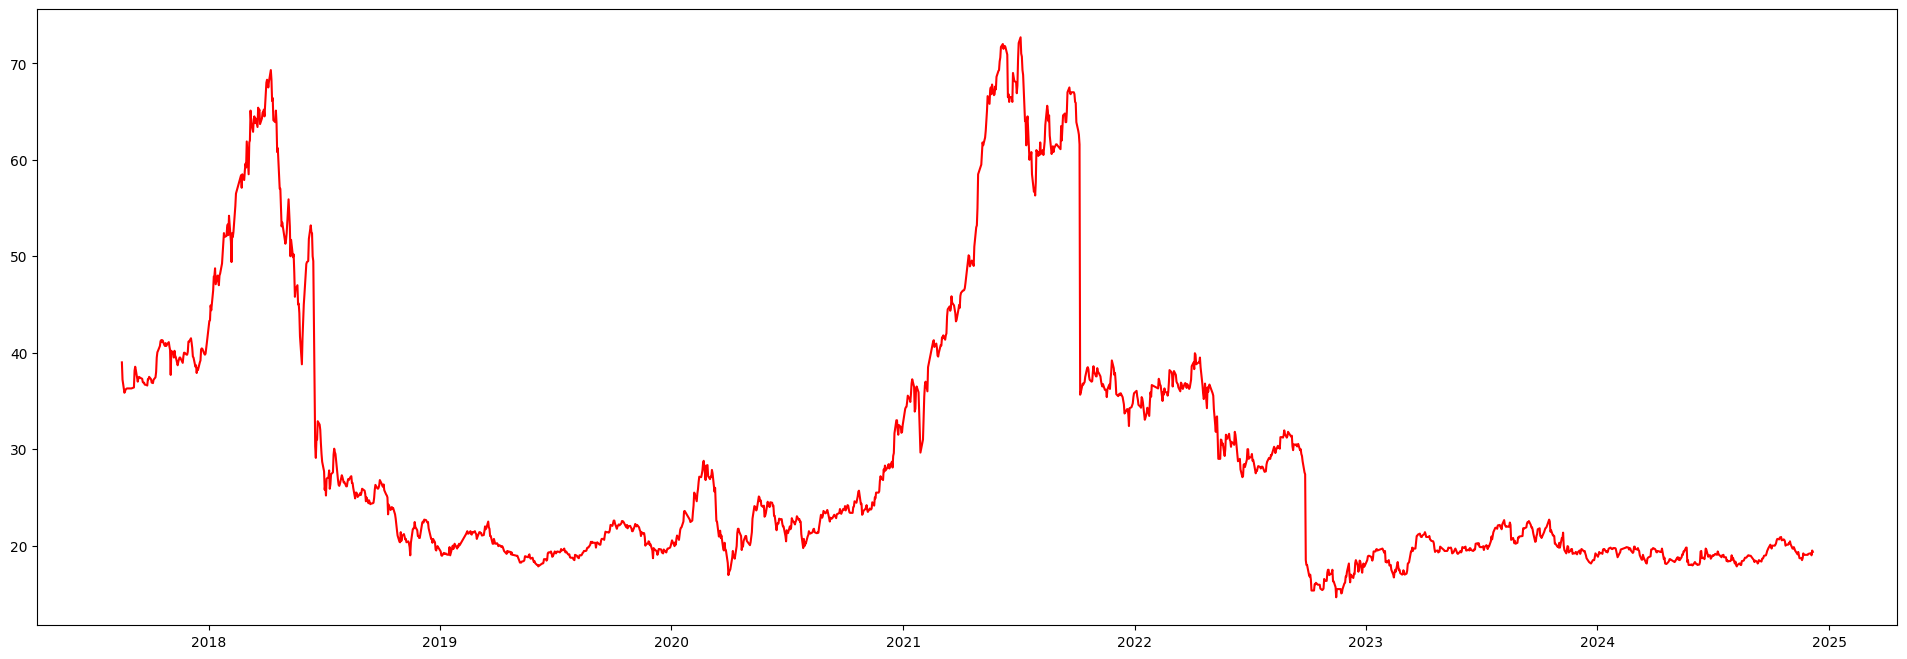

In [80]:
# Thư viện cơ bản
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential  # type: ignore
from keras.layers import LSTM, Dropout, Dense  # type: ignore
from keras.callbacks import ModelCheckpoint  # type: ignore
from tensorflow.keras.models import load_model  # type: ignore
from pymongo import MongoClient
import os

# 2. Đọc Dữ Liệu
# Kết nối MongoDB và lấy dữ liệu
client = MongoClient("mongodb://localhost:27017/")  # Đường dẫn kết nối
db = client['metadata']  # Tên database
collections = ["VIC", "VJC", "VNM", "VPB", "VRE"]  # Danh sách các collection

# 3. Tiền Xử Lý Dữ Liệu cho mỗi Collection
for collection_name in collections:
    print(f"Xử lý dữ liệu cho Collection: {collection_name}")
    
    collection = db[collection_name]  # Lấy từng collection
    df = pd.DataFrame(list(collection.find({}, {"_id": 0})))  # Chuyển dữ liệu sang DataFrame
    
    # Kiểm tra dữ liệu
    print(df.info())
    print(df.describe())
    
    # Xử lý thời gian và sắp xếp dữ liệu
    df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
    df = df.sort_values(by='Ngay')

    # Chuyển đổi sang chỉ số thời gian
    df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
    df1.index = df1['Ngay']
    df1.drop('Ngay', axis=1, inplace=True)

    # Chia tập dữ liệu
    data = df1.values
    train_data = data[:int(len(df) * 0.8)]
    test_data = data[int(len(df) * 0.8):]

    # Chuẩn hóa dữ liệu
    sc = MinMaxScaler(feature_range=(0, 1))
    sc_train = sc.fit_transform(data)

    # Tạo cửa sổ thời gian cho tập train
    x_train, y_train = [], []
    for i in range(50, len(train_data)):
        x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
        y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # 5. Đánh Giá Mô Hình
    save_model_path = f"models/{collection_name}_model.keras"
    
    # Kiểm tra nếu mô hình đã tồn tại, tải mô hình nếu có
    if os.path.exists(save_model_path):
        print(f"Tải mô hình đã được huấn luyện cho {collection_name}")
        final_model = load_model(save_model_path)
    else:
        # Nếu mô hình chưa có, tạo và huấn luyện mô hình
        final_model = Sequential()
        final_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        final_model.add(Dropout(0.2))
        final_model.add(LSTM(units=50, return_sequences=False))
        final_model.add(Dropout(0.2))
        final_model.add(Dense(units=1))
        final_model.compile(optimizer='adam', loss='mean_squared_error')

        # Huấn luyện mô hình
        model_checkpoint = ModelCheckpoint(save_model_path, save_best_only=True)
        final_model.fit(x_train, y_train, epochs=10, batch_size=32, callbacks=[model_checkpoint])
        print(f"Mô hình cho {collection_name} đã được huấn luyện và lưu.")

    # Dự đoán trên tập train
    y_train_predict = final_model.predict(x_train)
    y_train_predict = sc.inverse_transform(y_train_predict)  # Inverse transform the predictions
    y_train = sc.inverse_transform(y_train.reshape(-1, 1))

    # Dự đoán trên tập test
    test = df1[len(train_data) - 50:].values
    test = test.reshape(-1, 1)
    sc_test = sc.transform(test)

    x_test = []
    for i in range(50, test.shape[0]):
        x_test.append(sc_test[i - 50:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    y_test_predict = final_model.predict(x_test)
    y_test_predict = sc.inverse_transform(y_test_predict)  # Inverse transform the predictions

    # Chia dữ liệu cho tập train và test để vẽ biểu đồ
    test_data1_resized = test_data1[:len(y_test_predict)]  # Cắt test_data1 để có độ dài khớp với y_test_predict

    # Gắn dự đoán vào test_data1
    test_data1_resized['Dự đoán'] = y_test_predict  # Gắn dự đoán vào test_data1_resized

    # Vẽ biểu đồ
    plt.figure(figsize=(24, 8))

    # Vẽ giá thực tế
    plt.plot(df1['GiaDongCua'], label='Giá thực tế', color='red')

    # Vẽ giá dự đoán trên tập train
    train_data1['Dự đoán'] = y_train_predict[:len(train_data1)]  # Gắn dự đoán vào train_data1
    plt.plot(train_data1['Dự đoán'], label='Giá dự đoán train', color='green')

    # Vẽ giá dự đoán trên tập test (sử dụng test_data1_resized)
    plt.plot(test_data1_resized['Dự đoán'], label='Giá dự đoán test', color='blue')

    # Đặt tiêu đề và nhãn cho các trục
    plt.title('So sánh giá dự báo và giá thực tế')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá đóng cửa (VNĐ)')

    # Hiển thị chú thích
    plt.legend()

    # Hiển thị biểu đồ
    plt.show()
    # 8. So Sánh Giá Dự Báo và Thực Tế
    # Lấy giá trị thực tế từ tập test
    actual_closing_price_test = df1['GiaDongCua'].iloc[len(train_data):].values
    
    # Ensure that the predicted values correspond to the last 30 dates of test data
    actual_last_30 = df['GiaDongCua'].iloc[-10:].values  # Last 30 actual values
    predicted_last_30 = y_test_predict[-10:].flatten()  # Ensure the prediction is 1D

    # Create a DataFrame comparing actual and predicted values for the last 30 days
    comparison_df = pd.DataFrame({
        'Ngày': df['Ngay'].iloc[-10:],  # Last 30 dates
        'Giá thực tế': actual_last_30,  # Actual closing prices for the last 30 days
        'Giá dự đoán': predicted_last_30  # Predicted closing prices for the last 30 days
    })

    print(comparison_df)

    print(f"Kết thúc xử lý cho {collection_name}\n")


Xử lý dữ liệu cho Collection: test_VIC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Ngay               860 non-null    datetime64[ns]
 1   GiaDongCua_ThucTe  860 non-null    float64       
 2   GiaDongCua_DuBao   860 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 20.3 KB
None
                                Ngay  GiaDongCua_ThucTe  GiaDongCua_DuBao
count                            860         860.000000        860.000000
mean   2023-01-07 17:41:34.883720960          67.078721         62.952782
min              2021-04-20 00:00:00          40.400000         41.443428
25%              2022-03-01 18:00:00          46.025000         45.651080
50%              2023-01-04 12:00:00          57.050000         55.105627
75%              2023-11-15 06:00:00          81.725000         78.092457

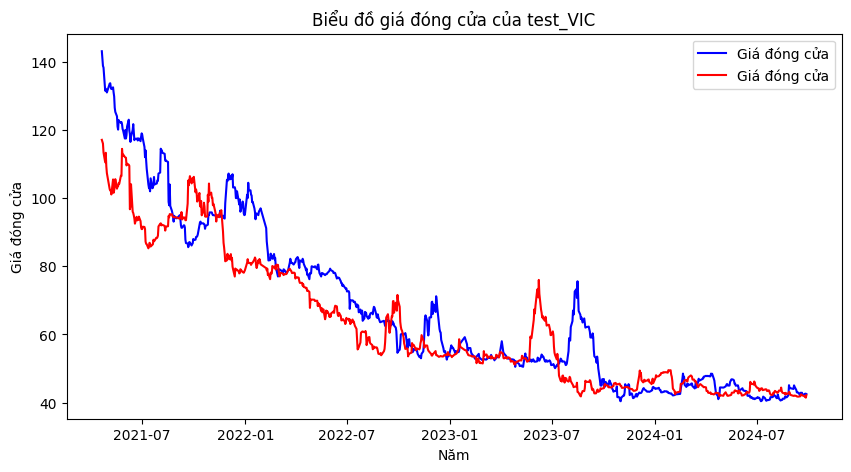

Xử lý dữ liệu cho Collection: test_VJC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Ngay               390 non-null    datetime64[ns]
 1   GiaDongCua_ThucTe  390 non-null    float64       
 2   GiaDongCua_DuBao   390 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 9.3 KB
None
                                Ngay  GiaDongCua_ThucTe  GiaDongCua_DuBao
count                            390         390.000000        390.000000
mean   2023-12-17 12:29:32.307692032         102.673333        103.532106
min              2023-03-09 00:00:00          93.800000         94.470520
25%              2023-07-27 06:00:00          99.300000        101.376022
50%              2023-12-13 12:00:00         103.000000        104.112900
75%              2024-05-12 06:00:00         105.300000        105.739725


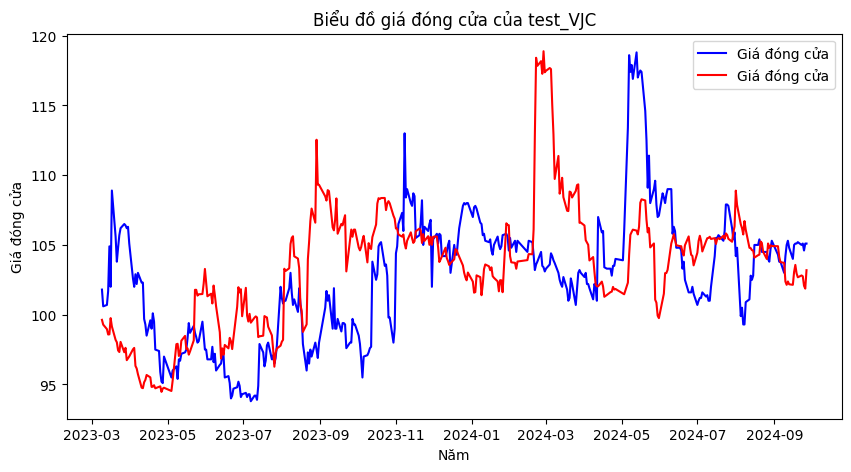

Xử lý dữ liệu cho Collection: test_VNM
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Ngay               943 non-null    datetime64[ns]
 1   GiaDongCua_ThucTe  943 non-null    float64       
 2   GiaDongCua_DuBao   943 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 22.2 KB
None
                                Ngay  GiaDongCua_ThucTe  GiaDongCua_DuBao
count                            943         943.000000        943.000000
mean   2022-11-07 23:14:11.325556992          78.723118         76.461481
min              2020-12-16 00:00:00          63.500000         62.338459
25%              2021-11-25 12:00:00          70.400000         68.535156
50%              2022-11-07 00:00:00          75.500000         74.242210
75%              2023-10-17 12:00:00          86.250000         82.840324

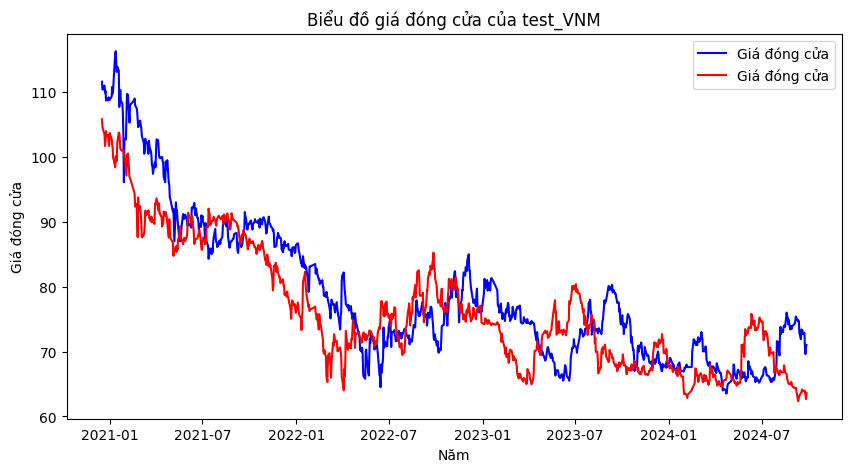

Xử lý dữ liệu cho Collection: test_VPB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Ngay               366 non-null    datetime64[ns]
 1   GiaDongCua_ThucTe  366 non-null    float64       
 2   GiaDongCua_DuBao   366 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.7 KB
None
                                Ngay  GiaDongCua_ThucTe  GiaDongCua_DuBao
count                            366         366.000000        366.000000
mean   2024-01-04 00:43:16.721311232          19.633607         19.532875
min              2023-04-12 00:00:00          17.850000         17.870943
25%              2023-08-22 06:00:00          18.800000         18.728618
50%              2023-12-31 00:00:00          19.450000         19.288011
75%              2024-05-20 18:00:00          19.937500         20.060309


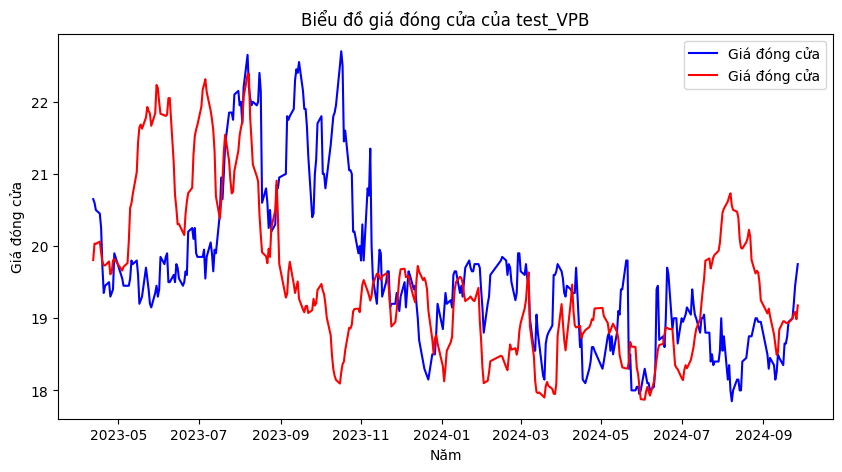

Xử lý dữ liệu cho Collection: test_VRE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Ngay               355 non-null    datetime64[ns]
 1   GiaDongCua_ThucTe  355 non-null    float64       
 2   GiaDongCua_DuBao   355 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.4 KB
None
                                Ngay  GiaDongCua_ThucTe  GiaDongCua_DuBao
count                            355         355.000000        355.000000
mean   2024-01-12 02:05:44.788732672          24.294930         23.378480
min              2023-04-27 00:00:00          16.800000         17.702675
25%              2023-09-05 12:00:00          22.125000         20.246706
50%              2024-01-09 00:00:00          23.750000         23.208570
75%              2024-05-23 12:00:00          27.025000         26.173184


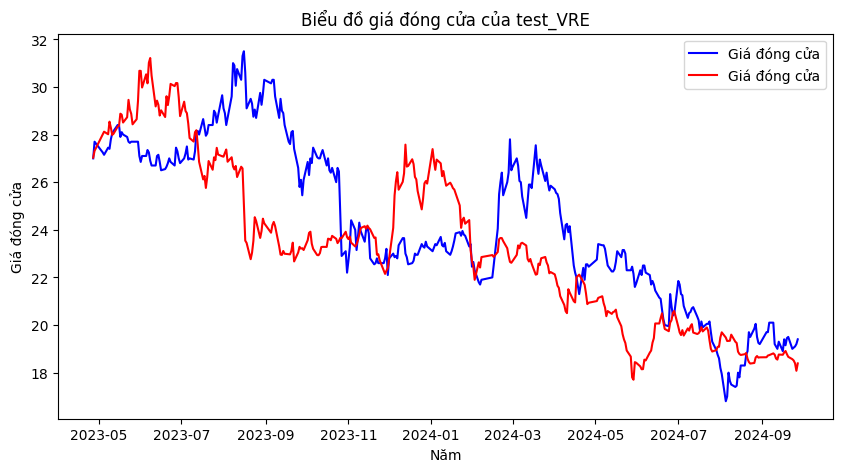

In [75]:
client = MongoClient("mongodb://localhost:27017/")  # Đường dẫn kết nối
db = client['metadata']  # Tên database
collections = ["test_VIC", "test_VJC", "test_VNM", "test_VPB", "test_VRE"]

# 3. Tiền Xử Lý Dữ Liệu cho mỗi Collection
for collection_name in collections:
    print(f"Xử lý dữ liệu cho Collection: {collection_name}")
    
    collection = db[collection_name]  # Lấy từng collection
    df = pd.DataFrame(list(collection.find({}, {"_id": 0})))  # Chuyển dữ liệu sang DataFrame
    
    df
    
    # Kiểm tra dữ liệu
    print(df.info())
    print(df.describe())
    
    # Xử lý thời gian và sắp xếp dữ liệu
    df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
    df = df.sort_values(by='Ngay')

    # Vẽ biểu đồ giá đóng cửa
    plt.figure(figsize=(10, 5))
    plt.plot(df['Ngay'], df['GiaDongCua_ThucTe'], label='Giá đóng cửa', color='blue')
    plt.plot(df['Ngay'], df['GiaDongCua_DuBao'], label='Giá đóng cửa', color='red')
    plt.xlabel('Năm')
    plt.ylabel('Giá đóng cửa')
    plt.title(f'Biểu đồ giá đóng cửa của {collection_name}')
    plt.legend(loc='best')
    plt.show()